<a href="https://colab.research.google.com/github/CharLLCH/14S003027-software_class_task/blob/master/textandregression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install tensorflow-gpu

     |████████████████████████████████| 421.8MB 38kB/s 
     |████████████████████████████████| 3.8MB 54.6MB/s 
     |████████████████████████████████| 450kB 55.7MB/s 
     |████████████████████████████████| 81kB 12.8MB/s 
ERROR: tensorflow 1.15.0 has requirement tensorboard<1.16.0,>=1.15.0, but you'll have tensorboard 2.1.0 which is incompatible.
ERROR: tensorflow 1.15.0 has requirement tensorflow-estimator==1.15.1, but you'll have tensorflow-estimator 2.1.0 which is incompatible.
ERROR: tensorboard 2.1.0 has requirement grpcio>=1.24.3, but you'll have grpcio 1.15.0 which is incompatible.
ERROR: google-colab 1.0.0 has requirement google-auth~=1.4.0, but you'll have google-auth 1.10.1 which is incompatible.
  Found existing installation: google-auth 1.4.2
    Uninstalling google-auth-1.4.2:
      Successfully uninstalled google-auth-1.4.2
  Found existing installation: tensorboard 1.15.0
    Uninstalling tensorboard-1.15.0:
      Successfully uninstalled tensorboard-1.15.0
  Found exis

In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals

import numpy as np

import tensorflow as tf

import tensorflow_hub as hub
import tensorflow_datasets as tfds

print("Version: ", tf.__version__)
print("Eager mode: ", tf.executing_eagerly())
print("Hub version: ", hub.__version__)
print("GPU is", "available" if tf.config.experimental.list_physical_devices("GPU") else "NOT AVAILABLE")

Version:  2.1.0
Eager mode:  True
Hub version:  0.7.0
GPU is available


In [2]:
# 将训练集按照 6:4 的比例进行切割，从而最终我们将得到 15,000
# 个训练样本, 10,000 个验证样本以及 25,000 个测试样本
train_validation_split = tfds.Split.TRAIN.subsplit([6, 4])

(train_data, validation_data), test_data = tfds.load(
    name="imdb_reviews", 
    split=(train_validation_split, tfds.Split.TEST),
    as_supervised=True)

Instructions for updating:
Use eager execution and: 
`tf.data.TFRecordDataset(path)`


Instructions for updating:
Use eager execution and: 
`tf.data.TFRecordDataset(path)`


Dataset imdb_reviews downloaded and prepared to /root/tensorflow_datasets/imdb_reviews/plain_text/0.1.0. Subsequent calls will reuse this data.


In [3]:
train_examples_batch, train_labels_batch = next(iter(train_data.batch(10)))
train_examples_batch

<tf.Tensor: shape=(10,), dtype=string, numpy=
array([b"As a lifelong fan of Dickens, I have invariably been disappointed by adaptations of his novels.<br /><br />Although his works presented an extremely accurate re-telling of human life at every level in Victorian Britain, throughout them all was a pervasive thread of humour that could be both playful or sarcastic as the narrative dictated. In a way, he was a literary caricaturist and cartoonist. He could be serious and hilarious in the same sentence. He pricked pride, lampooned arrogance, celebrated modesty, and empathised with loneliness and poverty. It may be a clich\xc3\xa9, but he was a people's writer.<br /><br />And it is the comedy that is so often missing from his interpretations. At the time of writing, Oliver Twist is being dramatised in serial form on BBC television. All of the misery and cruelty is their, but non of the humour, irony, and savage lampoonery. The result is just a dark, dismal experience: the story penned by

In [4]:
train_labels_batch

<tf.Tensor: shape=(10,), dtype=int64, numpy=array([1, 1, 1, 1, 1, 1, 0, 1, 1, 0])>

In [5]:
embedding = "https://tfhub.dev/google/tf2-preview/gnews-swivel-20dim/1"
hub_layer = hub.KerasLayer(embedding, input_shape=[], 
                           dtype=tf.string, trainable=True)
hub_layer(train_examples_batch[:3])

<tf.Tensor: shape=(3, 20), dtype=float32, numpy=
array([[ 3.9819887 , -4.4838037 ,  5.177359  , -2.3643482 , -3.2938678 ,
        -3.5364532 , -2.4786978 ,  2.5525482 ,  6.688532  , -2.3076782 ,
        -1.9807833 ,  1.1315885 , -3.0339816 , -0.7604128 , -5.743445  ,
         3.4242578 ,  4.790099  , -4.03061   , -5.992149  , -1.7297493 ],
       [ 3.4232912 , -4.230874  ,  4.1488533 , -0.29553518, -6.802391  ,
        -2.5163853 , -4.4002395 ,  1.905792  ,  4.7512794 , -0.40538004,
        -4.3401685 ,  1.0361497 ,  0.9744097 ,  0.71507156, -6.2657013 ,
         0.16533905,  4.560262  , -1.3106939 , -3.1121316 , -2.1338716 ],
       [ 3.8508697 , -5.003031  ,  4.8700504 , -0.04324996, -5.893603  ,
        -5.2983093 , -4.004676  ,  4.1236343 ,  6.267754  ,  0.11632943,
        -3.5934832 ,  0.8023905 ,  0.56146765,  0.9192484 , -7.3066816 ,
         2.8202746 ,  6.2000837 , -3.5709393 , -4.564525  , -2.305622  ]],
      dtype=float32)>

In [6]:
model = tf.keras.Sequential()
model.add(hub_layer)
model.add(tf.keras.layers.Dense(16, activation='relu'))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     (None, 20)                400020    
_________________________________________________________________
dense (Dense)                (None, 16)                336       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 17        
Total params: 400,373
Trainable params: 400,373
Non-trainable params: 0
_________________________________________________________________


In [0]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [9]:
history = model.fit(train_data.shuffle(10000).batch(512),
                    epochs=20,
                    validation_data=validation_data.batch(512),
                    verbose=1)

Epoch 1/20
30/30 [==============================] - 6s 191ms/step - loss: 0.8107 - accuracy: 0.5497 - val_loss: 0.6806 - val_accuracy: 0.6072
Epoch 2/20
30/30 [==============================] - 5s 161ms/step - loss: 0.6392 - accuracy: 0.6407 - val_loss: 0.6124 - val_accuracy: 0.6666
Epoch 3/20
30/30 [==============================] - 5s 162ms/step - loss: 0.5870 - accuracy: 0.6936 - val_loss: 0.5715 - val_accuracy: 0.7088
Epoch 4/20
30/30 [==============================] - 5s 173ms/step - loss: 0.5491 - accuracy: 0.7277 - val_loss: 0.5387 - val_accuracy: 0.7353
Epoch 5/20
30/30 [==============================] - 5s 174ms/step - loss: 0.5136 - accuracy: 0.7593 - val_loss: 0.5091 - val_accuracy: 0.7570
Epoch 6/20
30/30 [==============================] - 5s 178ms/step - loss: 0.4826 - accuracy: 0.7833 - val_loss: 0.4850 - val_accuracy: 0.7708
Epoch 7/20
30/30 [==============================] - 6s 187ms/step - loss: 0.4512 - accuracy: 0.8011 - val_loss: 0.4559 - val_accuracy: 0.7951
Epoch 

In [10]:
results = model.evaluate(test_data.batch(512), verbose=2)
for name, value in zip(model.metrics_names, results):
  print("%s: %.3f" % (name, value))

loss: 0.317
accuracy: 0.865


In [11]:
# 一个映射单词到整数索引的词典
word_index = imdb.get_word_index()

# 保留第一个索引
word_index = {k:(v+3) for k,v in word_index.items()}
word_index["<PAD>"] = 0
word_index["<START>"] = 1
word_index["<UNK>"] = 2  # unknown
word_index["<UNUSED>"] = 3

reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])

def decode_review(text):
    return ' '.join([reverse_word_index.get(i, '?') for i in text])

NameError: ignored

In [12]:
imdb = keras.datasets.imdb

(train_data, train_labels), (test_data, test_labels) = imdb.load_data(num_words=10000)

NameError: ignored

In [13]:
from __future__ import absolute_import, division, print_function, unicode_literals

import tensorflow as tf
from tensorflow import keras

import numpy as np

print(tf.__version__)

2.1.0


In [14]:
imdb = keras.datasets.imdb

(train_data, train_labels), (test_data, test_labels) = imdb.load_data(num_words=10000)

17465344/17464789 [==============================] - 1s 0us/step


In [15]:
# 一个映射单词到整数索引的词典
word_index = imdb.get_word_index()

# 保留第一个索引
word_index = {k:(v+3) for k,v in word_index.items()}
word_index["<PAD>"] = 0
word_index["<START>"] = 1
word_index["<UNK>"] = 2  # unknown
word_index["<UNUSED>"] = 3

reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])

def decode_review(text):
    return ' '.join([reverse_word_index.get(i, '?') for i in text])

1646592/1641221 [==============================] - 0s 0us/step


In [16]:
decode_review(train_data[0])

"<START> this film was just brilliant casting location scenery story direction everyone's really suited the part they played and you could just imagine being there robert <UNK> is an amazing actor and now the same being director <UNK> father came from the same scottish island as myself so i loved the fact there was a real connection with this film the witty remarks throughout the film were great it was just brilliant so much that i bought the film as soon as it was released for <UNK> and would recommend it to everyone to watch and the fly fishing was amazing really cried at the end it was so sad and you know what they say if you cry at a film it must have been good and this definitely was also <UNK> to the two little boy's that played the <UNK> of norman and paul they were just brilliant children are often left out of the <UNK> list i think because the stars that play them all grown up are such a big profile for the whole film but these children are amazing and should be praised for wh

In [0]:
train_data = keras.preprocessing.sequence.pad_sequences(train_data,
                                                        value=word_index["<PAD>"],
                                                        padding='post',
                                                        maxlen=256)

test_data = keras.preprocessing.sequence.pad_sequences(test_data,
                                                       value=word_index["<PAD>"],
                                                       padding='post',
                                                       maxlen=256)
# 由于电影评论长度必须相同，我们将使用 pad_sequences 函数来使长度标准化：

In [19]:
len(train_data[0]), len(train_data[1])

(256, 256)

In [20]:
print(train_data[0])

[   1   14   22   16   43  530  973 1622 1385   65  458 4468   66 3941
    4  173   36  256    5   25  100   43  838  112   50  670    2    9
   35  480  284    5  150    4  172  112  167    2  336  385   39    4
  172 4536 1111   17  546   38   13  447    4  192   50   16    6  147
 2025   19   14   22    4 1920 4613  469    4   22   71   87   12   16
   43  530   38   76   15   13 1247    4   22   17  515   17   12   16
  626   18    2    5   62  386   12    8  316    8  106    5    4 2223
 5244   16  480   66 3785   33    4  130   12   16   38  619    5   25
  124   51   36  135   48   25 1415   33    6   22   12  215   28   77
   52    5   14  407   16   82    2    8    4  107  117 5952   15  256
    4    2    7 3766    5  723   36   71   43  530  476   26  400  317
   46    7    4    2 1029   13  104   88    4  381   15  297   98   32
 2071   56   26  141    6  194 7486   18    4  226   22   21  134  476
   26  480    5  144   30 5535   18   51   36   28  224   92   25  104
    4 

In [21]:
# 输入形状是用于电影评论的词汇数目（10,000 词）
vocab_size = 10000

model = keras.Sequential()
model.add(keras.layers.Embedding(vocab_size, 16))
model.add(keras.layers.GlobalAveragePooling1D())
model.add(keras.layers.Dense(16, activation='relu'))
model.add(keras.layers.Dense(1, activation='sigmoid'))

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 16)          160000    
_________________________________________________________________
global_average_pooling1d (Gl (None, 16)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 16)                272       
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 17        
Total params: 160,289
Trainable params: 160,289
Non-trainable params: 0
_________________________________________________________________


In [0]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [0]:
x_val = train_data[:10000]
partial_x_train = train_data[10000:]

y_val = train_labels[:10000]
partial_y_train = train_labels[10000:]

In [24]:
history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=40,
                    batch_size=512,
                    validation_data=(x_val, y_val),
                    verbose=1)

Train on 15000 samples, validate on 10000 samples
Epoch 1/40
15000/15000 [==============================] - 1s 65us/sample - loss: 0.6915 - accuracy: 0.5946 - val_loss: 0.6893 - val_accuracy: 0.5978
Epoch 2/40
15000/15000 [==============================] - 1s 36us/sample - loss: 0.6844 - accuracy: 0.6839 - val_loss: 0.6791 - val_accuracy: 0.7392
Epoch 3/40
15000/15000 [==============================] - 1s 35us/sample - loss: 0.6693 - accuracy: 0.7595 - val_loss: 0.6606 - val_accuracy: 0.7523
Epoch 4/40
15000/15000 [==============================] - 1s 35us/sample - loss: 0.6437 - accuracy: 0.7713 - val_loss: 0.6319 - val_accuracy: 0.7697
Epoch 5/40
15000/15000 [==============================] - 1s 35us/sample - loss: 0.6066 - accuracy: 0.7939 - val_loss: 0.5934 - val_accuracy: 0.7883
Epoch 6/40
15000/15000 [==============================] - 1s 35us/sample - loss: 0.5613 - accuracy: 0.8130 - val_loss: 0.5497 - val_accuracy: 0.8033
Epoch 7/40
15000/15000 [==============================] 

In [25]:
results = model.evaluate(test_data,  test_labels, verbose=2)

print(results)

25000/25000 - 2s - loss: 0.3339 - accuracy: 0.8724
[0.33387627046585083, 0.87244]


In [26]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

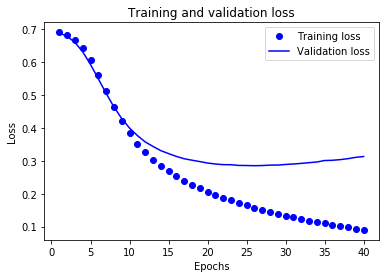

In [27]:
import matplotlib.pyplot as plt

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# “bo”代表 "蓝点"
plt.plot(epochs, loss, 'bo', label='Training loss')
# b代表“蓝色实线”
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

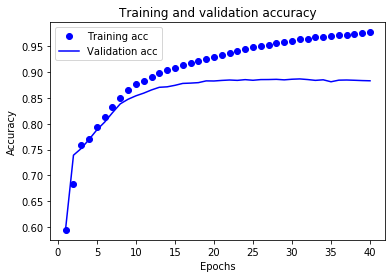

In [28]:
plt.clf()   # 清除数字

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [0]:
# 使用 seaborn 绘制矩阵图 (pairplot)
!pip install -q seaborn

In [30]:
from __future__ import absolute_import, division, print_function, unicode_literals

import pathlib

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers

print(tf.__version__)

2.1.0


In [31]:
dataset_path = keras.utils.get_file("auto-mpg.data", "http://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data")
dataset_path

32768/30286 [================================] - 0s 5us/step


'/root/.keras/datasets/auto-mpg.data'

In [32]:
column_names = ['MPG','Cylinders','Displacement','Horsepower','Weight',
                'Acceleration', 'Model Year', 'Origin']
raw_dataset = pd.read_csv(dataset_path, names=column_names,
                      na_values = "?", comment='\t',
                      sep=" ", skipinitialspace=True)

dataset = raw_dataset.copy()
dataset.tail()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Origin
393,27.0,4,140.0,86.0,2790.0,15.6,82,1
394,44.0,4,97.0,52.0,2130.0,24.6,82,2
395,32.0,4,135.0,84.0,2295.0,11.6,82,1
396,28.0,4,120.0,79.0,2625.0,18.6,82,1
397,31.0,4,119.0,82.0,2720.0,19.4,82,1


In [33]:
dataset.isna().sum()

MPG             0
Cylinders       0
Displacement    0
Horsepower      6
Weight          0
Acceleration    0
Model Year      0
Origin          0
dtype: int64

In [0]:
dataset = dataset.dropna()

In [0]:
origin = dataset.pop('Origin')

In [36]:
dataset['USA'] = (origin == 1)*1.0
dataset['Europe'] = (origin == 2)*1.0
dataset['Japan'] = (origin == 3)*1.0
dataset.tail()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,USA,Europe,Japan
393,27.0,4,140.0,86.0,2790.0,15.6,82,1.0,0.0,0.0
394,44.0,4,97.0,52.0,2130.0,24.6,82,0.0,1.0,0.0
395,32.0,4,135.0,84.0,2295.0,11.6,82,1.0,0.0,0.0
396,28.0,4,120.0,79.0,2625.0,18.6,82,1.0,0.0,0.0
397,31.0,4,119.0,82.0,2720.0,19.4,82,1.0,0.0,0.0


In [0]:
train_dataset = dataset.sample(frac=0.8,random_state=0)
test_dataset = dataset.drop(train_dataset.index)

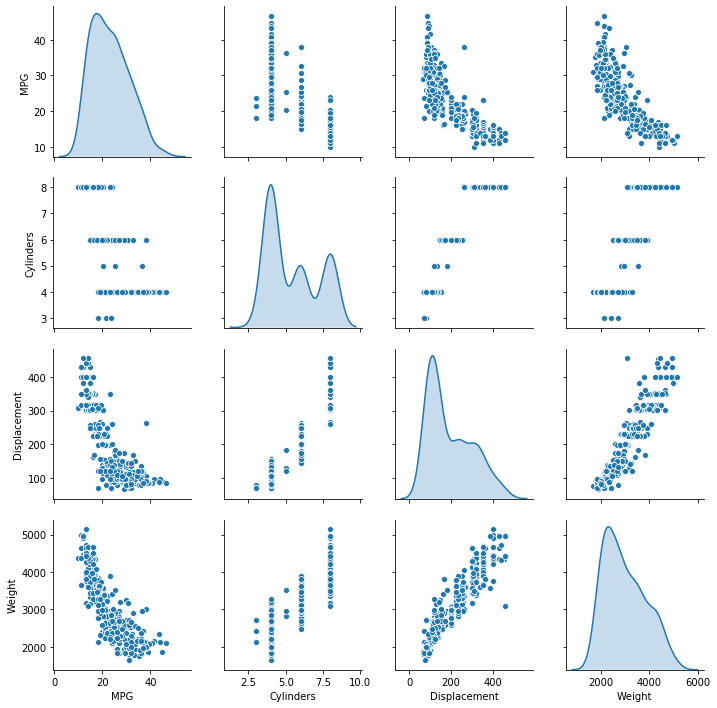

In [39]:
sns.pairplot(train_dataset[["MPG", "Cylinders", "Displacement", "Weight"]], diag_kind="kde")

In [40]:
train_stats = train_dataset.describe()
train_stats.pop("MPG")
train_stats = train_stats.transpose()
train_stats

,count,mean,std,min,25%,50%,75%,max
Cylinders,314.0,5.477707,1.699788,3.0,4.00,4.0,8.00,8.0
Displacement,314.0,195.318471,104.331589,68.0,105.50,151.0,265.75,455.0
Horsepower,314.0,104.869427,38.096214,46.0,76.25,94.5,128.00,225.0
Weight,314.0,2990.251592,843.898596,1649.0,2256.50,2822.5,3608.00,5140.0
Acceleration,314.0,15.559236,2.789230,8.0,13.80,15.5,17.20,24.8
Model Year,314.0,75.898089,3.675642,70.0,73.00,76.0,79.00,82.0
USA,314.0,0.624204,0.485101,0.0,0.00,1.0,1.00,1.0
Europe,314.0,0.178344,0.383413,0.0,0.00,0.0,0.00,1.0
Japan,314.0,0.197452,0.398712,0.0,0.00,0.0,0.00,1.0


In [0]:
train_labels = train_dataset.pop('MPG')
test_labels = test_dataset.pop('MPG')

In [0]:
def norm(x):
  return (x - train_stats['mean']) / train_stats['std']
normed_train_data = norm(train_dataset)
normed_test_data = norm(test_dataset)

In [0]:
def build_model():
  model = keras.Sequential([
    layers.Dense(64, activation='relu', input_shape=[len(train_dataset.keys())]),
    layers.Dense(64, activation='relu'),
    layers.Dense(1)
  ])

  optimizer = tf.keras.optimizers.RMSprop(0.001)

  model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])
  return model

In [0]:
model = build_model()

In [45]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 64)                640       
_________________________________________________________________
dense_5 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 65        
Total params: 4,865
Trainable params: 4,865
Non-trainable params: 0
_________________________________________________________________


In [46]:
example_batch = normed_train_data[:10]
example_result = model.predict(example_batch)
example_result

array([[-0.63184714],
       [-0.35544115],
       [-0.52243835],
       [-0.43572852],
       [-0.10833971],
       [-0.15133286],
       [-0.1377702 ],
       [-0.08098418],
       [-0.20510164],
       [-0.45814574]], dtype=float32)

In [47]:
# 通过为每个完成的时期打印一个点来显示训练进度
class PrintDot(keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs):
    if epoch % 100 == 0: print('')
    print('.', end='')

EPOCHS = 1000

history = model.fit(
  normed_train_data, train_labels,
  epochs=EPOCHS, validation_split = 0.2, verbose=0,
  callbacks=[PrintDot()])


....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
..........................................................................................

In [48]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

,loss,mae,mse,val_loss,val_mae,val_mse,epoch
995,2.657506,1.005216,2.657506,9.196441,2.211369,9.196440,995
996,2.886383,1.070914,2.886383,9.030826,2.207536,9.030826,996
997,2.756728,1.085937,2.756727,9.361803,2.230031,9.361803,997
998,2.731188,1.053474,2.731188,9.842029,2.296555,9.842030,998
999,2.798108,1.062170,2.798108,9.378514,2.214941,9.378514,999


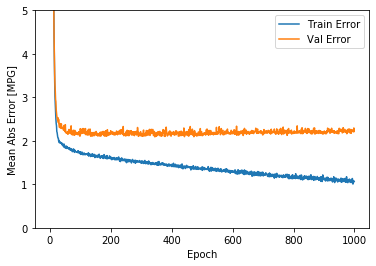

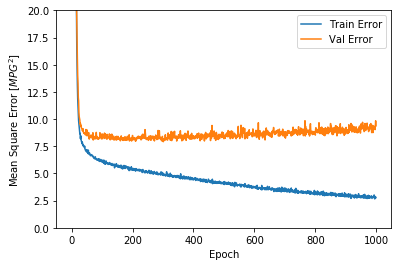

In [49]:
def plot_history(history):
  hist = pd.DataFrame(history.history)
  hist['epoch'] = history.epoch

  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Mean Abs Error [MPG]')
  plt.plot(hist['epoch'], hist['mae'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mae'],
           label = 'Val Error')
  plt.ylim([0,5])
  plt.legend()

  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Mean Square Error [$MPG^2$]')
  plt.plot(hist['epoch'], hist['mse'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mse'],
           label = 'Val Error')
  plt.ylim([0,20])
  plt.legend()
  plt.show()


plot_history(history)


...................................................

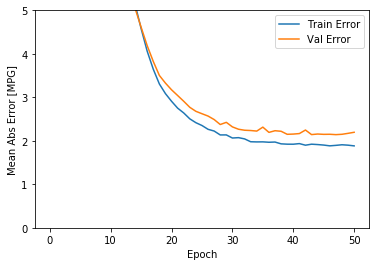

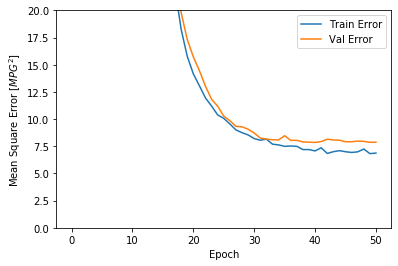

In [50]:
model = build_model()

# patience 值用来检查改进 epochs 的数量
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

history = model.fit(normed_train_data, train_labels, epochs=EPOCHS,
                    validation_split = 0.2, verbose=0, callbacks=[early_stop, PrintDot()])

plot_history(history)